In [54]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

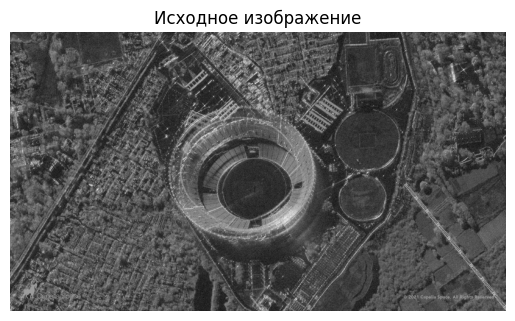

In [55]:
image = cv2.imread('sar_1.jpg')
# image = cv2.imread('img.jpg')

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.axis("off")
plt.show()

# Добавляем шум. Гаусс

In [56]:
mean, stddev = 0, 30
noise_gauss = np.random.normal(mean, stddev, image_gray.shape).astype(np.uint8)
image_gauss = cv2.add(image_gray, noise_gauss)

# Добавляем шум. Соль-перец

In [57]:
def add_salt_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy_image = np.copy(image)
    # белые точки
    salt_mask = np.random.random(image.shape) < salt_prob
    noisy_image[salt_mask] = 255
    # черные точки
    pepper_mask = np.random.random(image.shape) < pepper_prob
    noisy_image[pepper_mask] = 0
    return noisy_image

image_salt_pepper = add_salt_pepper_noise(image_gray, salt_prob=0.02, pepper_prob=0.02)

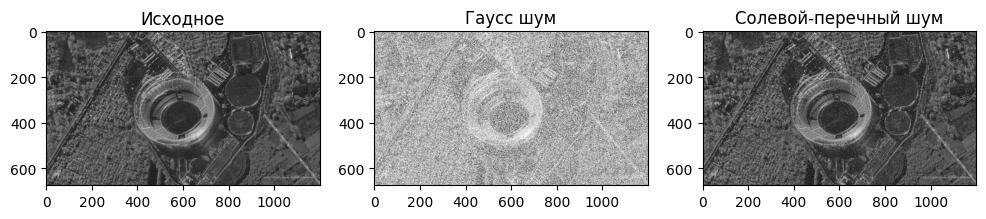

In [58]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(image_gray, cmap="gray"); plt.title("Исходное"); 
plt.subplot(1,3,2); plt.imshow(image_gauss, cmap="gray"); plt.title("Гаусс шум"); 
plt.subplot(1,3,3); plt.imshow(image_salt_pepper, cmap="gray"); plt.title("Солевой-перечный шум");
plt.show()

# Медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.

In [59]:
def test_filters(noisy, name=""):
    results = {}
    
    # медианный фильтр
    median = cv2.medianBlur(noisy, 3)
    results["median"] = (median, mean_squared_error(image_gray, median), structural_similarity(image_gray, median))

    # гауссов фильтр
    gauss = cv2.GaussianBlur(noisy, (5, 5), 1)
    results["gauss"] = (gauss, mean_squared_error(image_gray, gauss), structural_similarity(image_gray, gauss))

    # билатеральный фильтр
    bilateral = cv2.bilateralFilter(noisy, 9, 75, 75)
    results["bilateral"] = (bilateral, mean_squared_error(image_gray, bilateral), structural_similarity(image_gray, bilateral))
    
    # нелокальные средние
    nlm = cv2.fastNlMeansDenoising(noisy, h=15)
    results["nlm"] = (nlm, mean_squared_error(image_gray, nlm), structural_similarity(image_gray, nlm))
    

    print(f"\nРезультаты для {name} ")
    best = None
    for k, (img_filt, mse, ssim) in results.items():
        print(f"{k:12s} | MSE={mse:.2f}, SSIM={ssim:.4f}")
        if best is None or ssim > best[2]:
            best = (k, mse, ssim)
    
    print(f"Лучший: {best[0]} (SSIM={best[2]:.4f})")
    
    # вывод картинок
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].imshow(noisy, cmap="gray"); axs[0].set_title(f"{name} шум")
    axs[1].imshow(results["median"][0], cmap="gray"); axs[1].set_title("Median")
    axs[2].imshow(results["gauss"][0], cmap="gray"); axs[2].set_title("Gaussian")
    axs[3].imshow(results["bilateral"][0], cmap="gray"); axs[3].set_title("Bilateral")
    axs[4].imshow(results["nlm"][0], cmap="gray"); axs[4].set_title("NLM")
    plt.show()
    
    return results

ТЕСТИРОВАНИЕ ФИЛЬТРОВ

Результаты для Гаусса 
median       | MSE=16004.28, SSIM=0.0564
gauss        | MSE=10364.34, SSIM=0.2106
bilateral    | MSE=13874.91, SSIM=0.0758
nlm          | MSE=16015.39, SSIM=0.0574
Лучший: gauss (SSIM=0.2106)


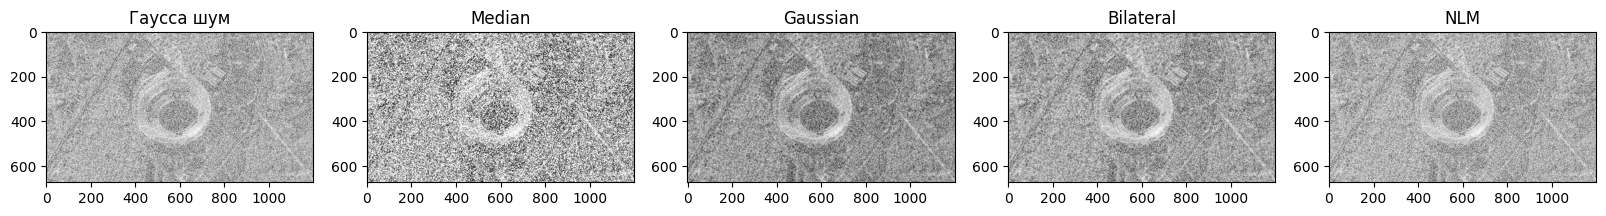


Результаты для Солевой-перечный 
median       | MSE=98.06, SSIM=0.8134
gauss        | MSE=173.51, SSIM=0.6957
bilateral    | MSE=357.27, SSIM=0.4655
nlm          | MSE=671.87, SSIM=0.5234
Лучший: median (SSIM=0.8134)


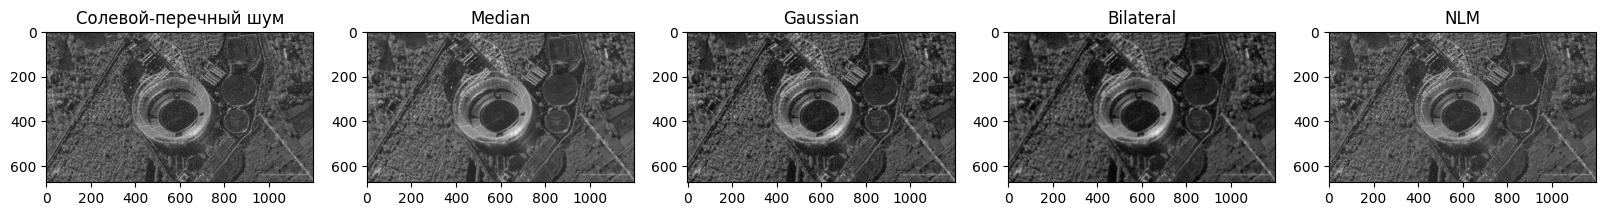

In [60]:
print("ТЕСТИРОВАНИЕ ФИЛЬТРОВ")

results_gauss = test_filters(image_gauss, "Гаусса")
results_salt_pepper = test_filters(image_salt_pepper, "Солевой-перечный")

ТЕСТИРОВАНИЕ ФИЛЬТРОВ С РАЗНЫМИ ПАРАМЕТРАМИ
1. Медианный фильтр:
Ядро 3x3: MSE=16004.28, SSIM=0.0564
Ядро 5x5: MSE=15878.52, SSIM=0.0562
Ядро 7x7: MSE=15663.73, SSIM=0.0633


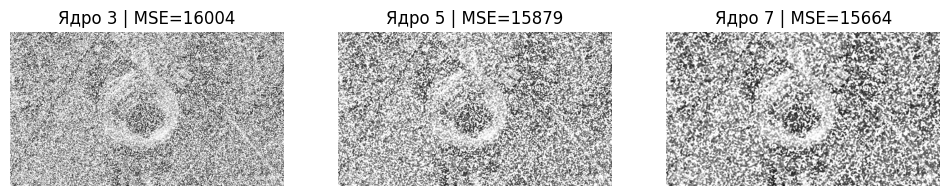

2. Гауссов фильтр:
Ядро 3x3 (σ=0.5): MSE=12376.03, SSIM=0.1015
Ядро 5x5 (σ=1.0): MSE=10364.34, SSIM=0.2106
Ядро 7x7 (σ=1.5): MSE=10135.60, SSIM=0.2424


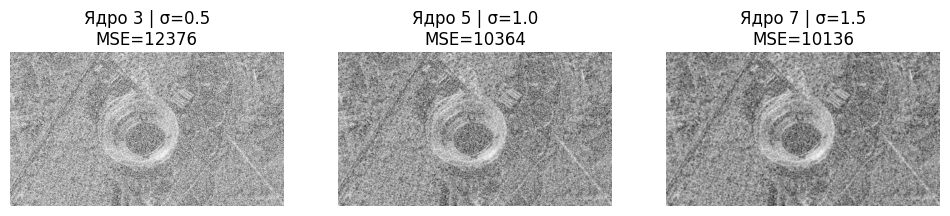

3. Билатеральный фильтр:
d=5: MSE=13904.66, SSIM=0.0795
d=9: MSE=13874.91, SSIM=0.0758
d=15: MSE=13839.54, SSIM=0.0722


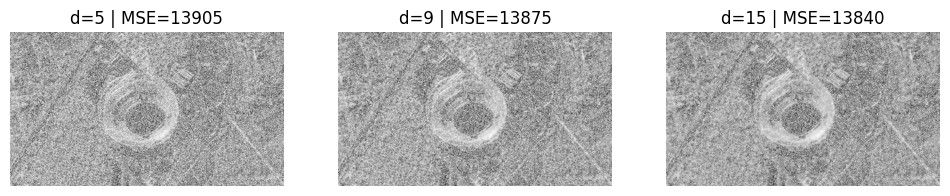

4. NLM фильтр:
h=10: MSE=16015.67, SSIM=0.0573
h=20: MSE=16014.35, SSIM=0.0575
h=30: MSE=15940.32, SSIM=0.0605


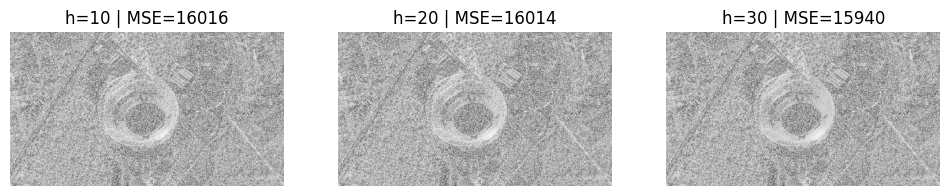

In [61]:
print("ТЕСТИРОВАНИЕ ФИЛЬТРОВ С РАЗНЫМИ ПАРАМЕТРАМИ")

print("1. Медианный фильтр:")
plt.figure(figsize=(12, 3))
for i, k in enumerate([3, 5, 7]):
    filtered = cv2.medianBlur(image_gauss, k)
    mse = mean_squared_error(image_gray, filtered)
    ssim_val = structural_similarity(image_gray, filtered)
    print(f"Ядро {k}x{k}: MSE={mse:.2f}, SSIM={ssim_val:.4f}")
    
    plt.subplot(1, 3, i+1)
    plt.imshow(filtered, cmap="gray")
    plt.title(f"Ядро {k} | MSE={mse:.0f}")
    plt.axis("off")
plt.show()

print("2. Гауссов фильтр:")
plt.figure(figsize=(12, 3))
for i, (k, s) in enumerate([(3, 0.5), (5, 1.0), (7, 1.5)]):
    filtered = cv2.GaussianBlur(image_gauss, (k, k), s)
    mse = mean_squared_error(image_gray, filtered)
    ssim_val = structural_similarity(image_gray, filtered)
    print(f"Ядро {k}x{k} (σ={s}): MSE={mse:.2f}, SSIM={ssim_val:.4f}")
    
    plt.subplot(1, 3, i+1)
    plt.imshow(filtered, cmap="gray")
    plt.title(f"Ядро {k} | σ={s}\nMSE={mse:.0f}")
    plt.axis("off")
plt.show()

print("3. Билатеральный фильтр:")
plt.figure(figsize=(12, 3))
for i, d in enumerate([5, 9, 15]):
    filtered = cv2.bilateralFilter(image_gauss, d, 75, 75)
    mse = mean_squared_error(image_gray, filtered)
    ssim_val = structural_similarity(image_gray, filtered)
    print(f"d={d}: MSE={mse:.2f}, SSIM={ssim_val:.4f}")
    
    plt.subplot(1, 3, i+1)
    plt.imshow(filtered, cmap="gray")
    plt.title(f"d={d} | MSE={mse:.0f}")
    plt.axis("off")
plt.show()

print("4. NLM фильтр:")
plt.figure(figsize=(12, 3))
for i, h in enumerate([10, 20, 30]):
    filtered = cv2.fastNlMeansDenoising(image_gauss, None, h, 7, 21)
    mse = mean_squared_error(image_gray, filtered)
    ssim_val = structural_similarity(image_gray, filtered)
    print(f"h={h}: MSE={mse:.2f}, SSIM={ssim_val:.4f}")
    
    plt.subplot(1, 3, i+1)
    plt.imshow(filtered, cmap="gray")
    plt.title(f"h={h} | MSE={mse:.0f}")
    plt.axis("off")
plt.show()